# COBAR 2023 Locomotion Code Submission

Please use this template to submit your code for your COBAR miniproject.

**PLEASE READ THE INSTRUCTIONS BELOW CAREFULLY.**

**Google Colab:** It is your responsibility to make sure that your code can be executed without error on Google Colab. You may use your own machine for development, but in the end we will use Colab to determine whether your code runs. You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."

**Where to put your code:** Please only fill your code in places indicated by the following. These cells are provided flexibly enough, and you should be able to easily add your custom import/loading/preprocessing/stepping code. You may also use common `*.py` module files and import functions/classes from these modules.
```Python
# ========== YOUR CODE BELOW ==========
... write your code here
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
```

**Terrain types:** Once you have completed this notebook for flat terrain, duplicate 2 more copies of this notebook, and change the terrain type to "gapped" and "blocks" respectively. Make sure you can run all three notebooks on Colab.

**Stabilization time:** Recall from the decentralized control demo: it might be helpful to first run a number of steps (`n_steps_stabil`) without locomotion so the fly has a chance to stabilize on the ground. This is allowed and does not count toward the 1-second simulation time.

**What to submit:** Please submit the following files via Moodle:
1. The three *executed* notebooks (ie. the outputs of the code blocks are printed). Name these files "submission_flat.ipynb", "submission_gapped.ipynb", and "submission_blocks.ipynb"
2. The three output videos: "output_flat.mp4", "output_gapped.mp4", and "output_blocks.mp4"
3. Any data file that are required for the notebooks to run (eg. parameter files, additional configurations, ...). In other words, include any file that you are loading to the notebooks. We will download these files to the same directory/folder as the notebook files before running the notebooks.
4. If you have any `*.py` module file from which you imported variables, functions, or classes, included these files too.

---

In [ ]:
# #@title Install `flygym` on Colab

# # This block is modified from dm_control's tutorial notebook
# # https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    print('Installing flygym')
    !pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during dm_control installation. Check the shell '
            'output above for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    print('Checking that the flygym installation succeeded...')
    try:
        import flygym
        from flygym import envs
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during flygym installation. Check the shell '
            'output above for more information.\n')
    else:
        del envs, flygym
else:
    print('Skipping - not on Colab')

Installing flygym
  Preparing metadata (setup.py) ... done
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Checking that the flygym installation succeeded...


You may install any additional packages here with pip. NumPy should already be installed; it's merely a demonstration of the syntax.

In [ ]:
# ========== YOUR CODE BELOW ==========
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install gymnasium==0.28.0 # remove ==0.28.0
!pip install "stable-baselines3[extra]==2.0.0a4" #>=
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

The following are some of the modules imported in the demo notebooks:

In [ ]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You may import any additional modules here:

In [ ]:
# ========== YOUR CODE BELOW ==========
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import mediapy
from flygym.util.config import all_tarsi_collisions_geoms
from shapely.geometry import Point, Polygon, LineString
from gymnasium import spaces
import gymnasium as gym
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


We select the terrain type here. **YOUR CODE MUST STILL WORK IF THIS IS CHANGED TO gapped OR blocks!**

In [ ]:
terrain_type = 'gapped'  # or 'gapped' or 'blocks' or 'flats'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We define some other physics parameters. Thess must not be changed.

In [ ]:
# You are allowed to slightly change the initial position of the fly
# if it immediately gets stuck due to unfortunate initial placement
# ========== YOUR CODE BELOW ==========
fly_pos = (0, 0, 300)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

run_time = 1
out_dir = Path(f'contest_submission_{terrain_type}')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': fly_pos,
                  'friction': (friction, 0.005, 0.0001)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You may load any preprogrammed data here and manipulate them as needed. This can include reference step kinematics (as used in the decentralized control and centralized control notebooks), or parameter files for your artificial neural network:

In [ ]:
# ========== YOUR CODE BELOW ==========

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate
timestep = 1e-4
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / timestep)
step_data_block_base = np.zeros((len(all_leg_dofs), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * timestep
for i, joint in enumerate(all_leg_dofs):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

# Manual Stance Correction
step_data_block_manualcorrect = step_data_block_base.copy()
for side in ["L", "R"]:
    step_data_block_manualcorrect[all_leg_dofs.index(f"joint_{side}MCoxa")] += np.deg2rad(10) # Protract the midlegs
    step_data_block_manualcorrect[all_leg_dofs.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs
    step_data_block_manualcorrect[all_leg_dofs.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    step_data_block_manualcorrect[all_leg_dofs.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[all_leg_dofs.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)

# Check load distribution from manual correction
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(all_tarsi_collisions_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)

# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
legs = ["RH", "LH", "RF", "LF", "RM", "LM"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(all_leg_dofs) # Take all joints
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in all_leg_dofs for i, leg in enumerate(legs) if leg in joint])

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next, initiate your NeuroMechFly simulation environment.

In [ ]:
class MyNMF(gym.Env):
    def __init__(self, **kwargs): 

        print(f' Kwargs: {kwargs.keys()}' )
        self.nmf = NeuroMechFlyMuJoCo(**kwargs)

        self.tarsus_5_indices = np.array([4, 9, 14, 19, 24, 29])

        self.action_space = spaces.Discrete(6, seed=42)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(self.tarsus_5_indices),))

        self.prevs_pos = 0
        self.distance_xy_prevs = 0
        self.step_counter = 0
        self.n_stabilisation_steps = 1000
        self.keep_same_action = 0

        n_joints = len(self.nmf.actuated_joints)
        leg_ids = np.arange(len(legs)).astype(int)
        self.joint_ids = np.arange(n_joints).astype(int)
        self.match_leg_to_joints = np.array([i  for joint in self.nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])
            
        # This serves to keep track of the advancement of each leg in the stepping sequence
        self.stepping_advancement = np.zeros(len(legs)).astype(int)


        # TO LOG
        self.network_actions = [] # does the network favor a certain distribution
        self.reward_distane_time_history = []
        self.reward_com_distance_history = []
        self.com_distance_history = []
        self.distance_to_goal_history = []
        self.x_pos_hist = []
        self.y_pos_hist = []
        self.side_stability_hist = []
        self.forward_backward_stability_hist = []
        self.pitch_hist = []
        self.roll_hist = []
        self.reward_hist = []
        self.episode_length_hist = []
        self.raw_obs_hist = []

    def _parse_obs(self, raw_obs):

        contact_forces = self.get_leg_contact_forces(raw_obs) # self.get_tarsi_contact_forces(raw_obs)
        features = [contact_forces.flatten()] # raw_obs['joints'][0, :].flatten(),

        return np.concatenate(features, dtype=np.float32)
    
    def reset(self):

        # reset stabilization counter for every new episode
        self.step_counter = 0
        self.num_steps_off_ground = 0
        self.keep_same_action = 0

        self.stepping_advancement = np.zeros(len(legs)).astype(int)
        raw_obs, info = self.nmf.reset()

        for _ in range(self.n_stabilisation_steps):
                action = {'joints': step_data_block_manualcorrect[self.joint_ids, 0]}
                raw_obs, info = self.nmf.step(action)

        # self.prevs_joints_pos = step_data_block_manualcorrect[self.joint_ids, 0]
        # self.prevs_orientation = raw_obs['fly'][2,:]

        self.prevs_pos = raw_obs['fly'][0,:]
        self.initial_pos_xy = raw_obs['fly'][0,:2]
        self.goal_pos_xy = self.initial_pos_xy + np.array([10000, 0])
        self.prevs_distance_to_goal = 10000

        self.initial_stance_roll_pitch = raw_obs['fly'][2, :2]

        return self._parse_obs(raw_obs), info
        
    def step(self, action):


        ##### ACTION #####
        # if the leg is already stepping

        if self.stepping_advancement[action] > 0:
          pass
        else:
          self.stepping_advancement[action] += 1

  
        joint_pos_new = step_data_block_manualcorrect[self.joint_ids, self.stepping_advancement[self.match_leg_to_joints]]
        raw_obs, info = self.nmf.step({'joints': joint_pos_new})
        self.stepping_advancement = self.update_stepping_advancement(legs, interp_step_duration)

        obs = self._parse_obs(raw_obs)
        self.stepping_advancement = self.update_stepping_advancement(legs, interp_step_duration)

        ##### REWARD #####
        reward_distance, distance_to_goal = self.get_distance_time_reward(raw_obs)
        reward_com, com_distance = self.get_com_reward(raw_obs)

        side_stability = self.get_delta_forces_side_stability(raw_obs)
        forward_backward_stability = self.get_delta_forces_forward_backward_stability(raw_obs)
        penalty_side_stability = -np.abs(side_stability)
        penalty_forward_backward_stability = -np.abs(forward_backward_stability)

        penalty_roll = -np.abs(raw_obs['fly'][2,0] - self.initial_stance_roll_pitch[0])
        penalty_pitch = -np.abs(raw_obs['fly'][2,1] - self.initial_stance_roll_pitch[1])

        self.reward = reward_distance # + penalty_roll + penalty_pitch # + penalty_side_stability + penalty_forward_backward_stability # + reward_com + penalty_stability

        #### LOGGING #####
        self.com_distance_history.append(com_distance)
        self.distance_to_goal_history.append(distance_to_goal)

        self.x_pos_hist.append(raw_obs['fly'][0, 0])
        self.y_pos_hist.append(raw_obs['fly'][0, 1])

        self.side_stability_hist.append(side_stability)
        self.forward_backward_stability_hist.append(forward_backward_stability)

        self.pitch_hist.append(raw_obs['fly'][2, 1])
        self.roll_hist.append(raw_obs['fly'][2, 0])

        self.reward_hist.append(self.reward)
        self.raw_obs_hist.append(raw_obs)
        # self.network_actions.append({self.step_counter: action})


        ###### TERMINATION #####
        terminated = self.is_terminated(raw_obs)
        truncated = False
        self.step_counter += 1

        if terminated:
          self.episode_length_hist.append(self.step_counter)

        return obs, self.reward, terminated, truncated, info

    def render(self):
        return self.nmf.render()
    
    def close(self):
        return self.nmf.close()

    def update_stepping_advancement(self, legs, interp_step_duration):

        # Advance the stepping advancement of each leg that are stepping, reset the advancement of the legs that are done stepping
        for k, leg in enumerate(legs):
          if self.stepping_advancement[k] >= interp_step_duration-1:
            self.stepping_advancement[k] = 0
          elif self.stepping_advancement[k] > 0:
            self.stepping_advancement[k] +=1
        return self.stepping_advancement
    
    def get_distance_time_reward(self, raw_obs):

        """
        Main reward function. Rewards and penalizes based on distance to goal 
        point and time taken.
        """

        reward = 0
        updated_pos = raw_obs['fly'][0, :2]
        updated_distance_to_goal = np.linalg.norm(self.goal_pos_xy - updated_pos)

        if updated_distance_to_goal < self.prevs_distance_to_goal:
          reward += 1
        else:
          reward += -0.1
        
        reward += -0.1 # naive time penalty - 0.01
        self.prevs_distance_to_goal = updated_distance_to_goal

        return reward, updated_distance_to_goal


    def get_com_reward(self, raw_obs):

        """
        Computes the minimum distance between the fly's center-of-mass and the
        nearest edge of a polygon passing through the contact points of the fly's 
        end-effectors with the planar ground as vertices.

        This metric is an adaptation form teh neuro-mechFly paper and aims to
        measure stability.
        """

        reward = 0
        tarsus_contact_forces = raw_obs['contact_forces'][self.tarsus_5_indices]
        contact_boolean = tarsus_contact_forces != 0

        # order ccw_contact_boolean 
        ccw_contact_boolean = []
        ccw_contact_boolean.extend(contact_boolean[:3])
        ccw_contact_boolean.extend(contact_boolean[::-1][:3])

        end_effector_positions = raw_obs['end_effectors']
        polygon_points_dict = {}
        ccw_list = ['LF', 'LM', 'LH', 'RH', 'RM', 'RF']

        if sum(ccw_contact_boolean) > 2: #i.e. Polygon with atleast 3 (4) sides, so that COM is always inside
          for i in range(len(ccw_contact_boolean)):
            if ccw_contact_boolean[i]:
              point = Point(end_effector_positions[i*3], end_effector_positions[i*3 + 1])
              polygon_points_dict.update({ccw_list[i]: point})
        else:
          reward = -1
          com_to_polygon_distance = -100
          return reward, com_to_polygon_distance

        polygon_list = []
        for leg_name in ccw_list:
          if leg_name in polygon_points_dict.keys():
            polygon_list.append(polygon_points_dict[leg_name])
        
        polygon = Polygon(polygon_list)
        com = raw_obs['fly'][0][:2]
        com_point = Point(com[0], com[1])
        com_to_polygon_distance = self._get_minimum_distance_point_to_polygon_edges(com_point, polygon)

        reward = 1/(1 + com_to_polygon_distance)

        return reward, com_to_polygon_distance

    def _get_minimum_distance_point_to_polygon_edges(self, point, polygon):
        
        distance = float('inf')
        coords = polygon.exterior.coords
        num_coords = len(coords)
        for i in range(num_coords - 1):
            edge_start = Point(coords[i])
            edge_end = Point(coords[i + 1])
            edge_line = LineString([edge_start, edge_end])
            edge_distance = point.distance(edge_line)
            distance = min(distance, edge_distance)
        
        return distance

    def get_tarsi_contact_forces(self, raw_obs):

        tarsus_contact_forces = raw_obs['contact_forces'][self.tarsus_5_indices]
        return tarsus_contact_forces

    def get_leg_contact_forces(self, raw_obs):

        leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])
        return leg_contact_forces
    
    def get_delta_forces_side_stability(self, raw_obs):

        """
        Computes difference between the averaged contact forces on the left and
        right legs of the fly.
        """

        legs_side_ordered = ["RF", "RM", "RH", "LF", "LM", "LH"]
        leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_side_ordered])

        delta_forces = np.sum(leg_contact_forces[:3])/3 - np.sum(leg_contact_forces[3:])/3
        
        return delta_forces # /1000

    def get_delta_forces_forward_backward_stability(self, raw_obs):

        """
        Computes difference between the averaged contact forces on the front and
        hind legs of the fly.
        """
        
        legs_forward_ordered = ["RF", "LF", "RH", "LH"]
        leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_forward_ordered])

        delta_forces = np.sum(leg_contact_forces[:2])/2 - np.sum(leg_contact_forces[2:])/2
        
        return delta_forces # /1000

    def is_terminated(self, raw_obs):

        """
        Defines termination conditions.
        """

        terminated = False

        if self.step_counter >= 10000:
          terminated = True
          return terminated
        
        updated_pos = raw_obs['fly'][0, :2]
        distance_to_goal = np.linalg.norm(self.goal_pos_xy - updated_pos)

        if distance_to_goal < 1000:
          terminate = True
          self.reward += 1000
          return terminate

        tarsus_contact_forces = raw_obs['contact_forces'][self.tarsus_5_indices]
        no_contact_boolean = tarsus_contact_forces == 0
        num_legs_off_ground = sum(no_contact_boolean)

        if num_legs_off_ground > 3:
          self.num_steps_off_ground += 1
          #TODO: add negative reward?
          # self.reward += -1
          if self.num_steps_off_ground > 1000:
            terminated = True
        else:
          self.num_steps_off_ground = 0
          terminated = False

        return terminated

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ========== YOUR CODE BELOW ==========

# nmf = NeuroMechFlyMuJoCo(
#     terrain=terrain_type,
#     render_mode='saved',
#     timestep=1e-4,
#     render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
#     init_pose='stretch',
#     actuated_joints=all_leg_dofs
# )

np.random.seed(42)

terrain_config = {'fly_pos': (0, 0, 2000),'friction': (friction, 0.005, 0.0001)} # 'fly_pos': (200, 0, 300)

nmf_train = MyNMF(render_mode='headless',
                         timestep=1e-4,
                         init_pose='stretch',
                         actuated_joints= all_leg_dofs,
                         terrain=terrain_type,
                         terrain_config = terrain_config)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Kwargs: dict_keys(['render_mode', 'timestep', 'init_pose', 'actuated_joints', 'terrain', 'terrain_config'])


You can add arbitrary code here after initializing the `nmf` object and before running the simulation loop:

In [ ]:
# ========== YOUR CODE BELOW ==========

# TRAINING
run_time = 1
num_steps = 100000 # run_time/1e-4
nmf_model = PPO(MlpPolicy, nmf_train, verbose=1)
nmf_model.learn(total_timesteps=num_steps, progress_bar=True)
nmf_train.close()
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

-----------------------------
| time/              |      |
|    fps             | 136  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 2            |
|    time_elapsed         | 25           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0093020955 |
|    clip_fraction        | 0.0619       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | 0.0119       |
|    learning_rate        | 0.0003       |
|    loss                 | 32.6         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0103      |
|    value_loss           | 92.2         |
------------------------------------------
----------------

In [ ]:
# nmf_train.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not 
call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any 
exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Now, run the simulation:

In [ ]:
# Final preparation here
# ========== YOUR CODE BELOW ==========

terrain_config = {'fly_pos': (0, 0, 2000),
                  'friction': (friction, 0.005, 0.0001)}
run_time = 1
num_steps = 10000
nmf = MyNMF(
    terrain=terrain_type,
    terrain_config = terrain_config,
    render_mode='saved',
    timestep=1e-4,
    render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
    init_pose='stretch',
    actuated_joints=all_leg_dofs
)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

obs, _ = nmf.reset()
x_pos_hist = []

# Main simulation loop
for i in trange(num_steps):
    # You may insert any code before stepping the physics simulation...
    # ========== YOUR CODE BELOW ==========

    action, _ = nmf_model.predict(obs)

    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    
    # ... and after stepping the physics simulation
    # ========== YOUR CODE BELOW ==========
    
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    # Report the final x position of the base of the fly here. If you wrote
    # a wrapper around `NeuroMechFlyMuJoCo` (for your own RL pipeline, for
    # example), you may modify the code below to faithfully report the final
    # x position of the base of the fly depending on your implementation.
    # Obviously, don't hard code a very large number :)
    # ========== YOUR CODE BELOW ==========
    # current_x_pos = obs['fly'][0, 0]
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    # x_pos_hist.append(current_x_pos)
    
# Save video here. SUBMIT THIS VIDEO ALONG WITH THE CODE!
nmf.nmf.save_video(out_dir / f"output_{terrain_type}.mp4")
nmf.nmf.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Kwargs: dict_keys(['terrain', 'terrain_config', 'render_mode', 'timestep', 'render_config', 'init_pose', 'actuated_joints'])


100%|██████████| 10000/10000 [06:00<00:00, 27.75it/s]


The video should have been saved to `out_dir / f"output_{terrain_type}.mp4"`. Check that it makes sense.

Finally, let's visualize how the fly's x position changes over time:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final X position: 9.6390 mm
Final Y position: -5.0828 mm


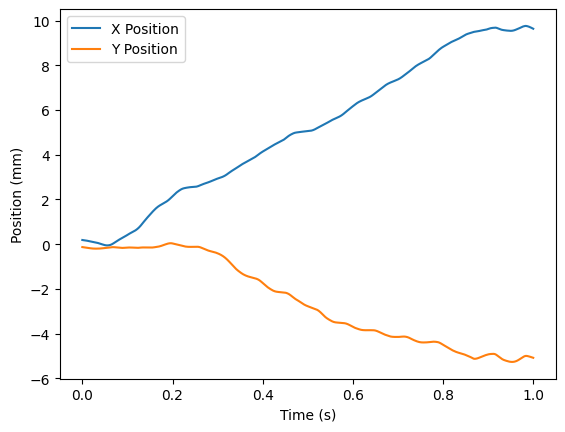

In [ ]:
x_pos_hist = nmf.x_pos_hist
plt.plot(np.arange(num_steps) * nmf.nmf.timestep, np.array(x_pos_hist) / 1000)

y_pos_hist = nmf.y_pos_hist
plt.plot(np.arange(num_steps) * nmf.nmf.timestep, np.array(y_pos_hist) / 1000)

plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')
plt.legend(labels=['X Position', 'Y Position'])

print(f'Final X position: {x_pos_hist[-1] / 1000:.4f} mm')
print(f'Final Y position: {y_pos_hist[-1] / 1000:.4f} mm')

plt.savefig('/content/drive/MyDrive/cobar/results/gapped/x_pos.jpeg')